# Introduction

Captcha is a type of challenge-response test used in computing to determine whether the user is human [1].
The challenge consists of obscuring a message from computer interpretation, for example, by twisting the letters and adding a slight background color gradient.
It was designed to be easily recognized by humans and difficult to identify by machines or robots in order to prevent harmful Internet attacks and increase the security of websites

Captcha can take multiple shapes, such as text-based, picture-based, and sound-based. In this work, we'll handle text-based Captcha.


# Import dependencies

In [1]:
import os
import string
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.svm import SVC

import tensorflow as tf

from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization

from keras.layers import Dropout
from keras.layers import Input
from keras.models import load_model

from sklearn.metrics import accuracy_score, classification_report
from keras.preprocessing.image import img_to_array, ImageDataGenerator

# Dataset

Our dataset contains Captcha images with exactly 5 alphanumeric characters with some distortion, noise, and blur applied to them.The images also have a single line crossing the characters, one of the defense mechanism previously mentioned to difficult the recognition process.

We have, in total, 1040 images, which we stored in the folder "archive/samples". Each image has 50x200 pixels.


## View a Sample

(-0.5, 199.5, 49.5, -0.5)

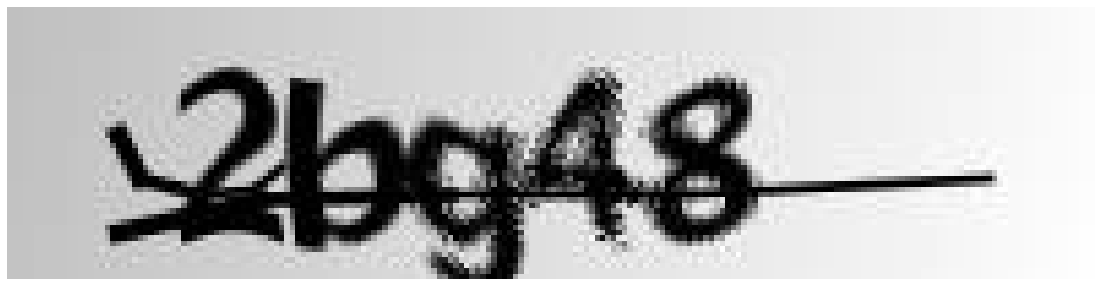

In [2]:
plt.figure(figsize = (20,5))
plt.imshow(cv2.imread('./archive/samples/2bg48.png', cv2.IMREAD_GRAYSCALE), 'gray')
    
plt.axis('off')

## Data Preprocessing

In order to improve the performance of our models, we've:

- Normalized the data
- Removed all the noise applied to the images (by smoothing out the images and removing the stroke crossing the characters)
- Separated out each one of the 5 letters in the image (i.e. segmentation, a technique we mentioned previously)

After all these steps, the characters are ready to be fed to the models individually.





(-0.5, 199.5, 49.5, -0.5)

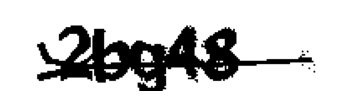

In [3]:
img = cv2.imread('./archive/samples/2bg48.png', cv2.IMREAD_GRAYSCALE)

def pixel_threshold(img):
    return cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)

img = pixel_threshold(img)
plt.imshow(img, 'gray')
plt.axis('off')

(-0.5, 199.5, 49.5, -0.5)

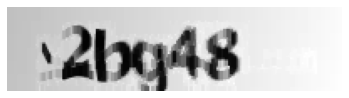

In [4]:
img = cv2.imread('./archive/samples/2bg48.png', cv2.IMREAD_GRAYSCALE)

def closing(img):
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((5,2), np.uint8))

img = closing(img)
plt.imshow(img, 'gray')
plt.axis('off')

(-0.5, 199.5, 49.5, -0.5)

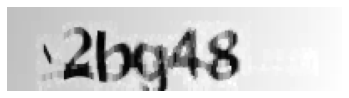

In [5]:
def dilation(img) :
    return cv2.dilate(img, np.ones((2,2), np.uint8), iterations = 1)

img = dilation(img)
plt.imshow(img, 'gray')
plt.axis('off')

(-0.5, 199.5, 49.5, -0.5)

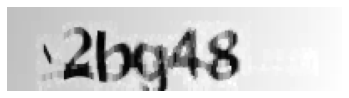

In [6]:
def smoothing(img) :
    return cv2.GaussianBlur(img, (1,1), 0)

img = smoothing(img)
plt.imshow(img, 'gray')
plt.axis('off')

(-0.5, 199.5, 49.5, -0.5)

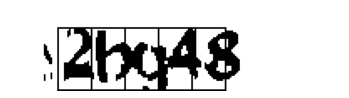

In [7]:
def data_preprocessing(img):
    
    # Adaptive Thresholding
    img = pixel_threshold(img)
    
    # Closing
    img = closing(img)
    
    # Dilation
    img = dilation(img)
    
    # Smoothing Images
    img = smoothing(img)
    
    # Partitioning
    cv2.rectangle(img, (30,12), (50,49), 0, 1)
    cv2.rectangle(img, (50,12), (70,49), 0, 1)
    cv2.rectangle(img, (70,12), (90,49), 0, 1)
    cv2.rectangle(img, (90,12), (110,49),0, 1)
    cv2.rectangle(img, (110,12),(130,49),0, 1)
    
    return img

img = cv2.imread('./archive/samples/2bg48.png', cv2.IMREAD_GRAYSCALE)
img = data_preprocessing(img)
plt.imshow(img, 'gray')
plt.axis('off')

## Load Data

In [8]:
X = []
y = []

for image in os.listdir('./archive/samples') :

    # Load image
    img = cv2.imread(os.path.join('./archive/samples', image), cv2.IMREAD_GRAYSCALE)
    
    # Apply preprocessing steps
    img = data_preprocessing(img)
    
    image_list = [img[10:50, 30:50], img[10:50, 50:70], img[10:50, 70:90], img[10:50, 90:110], img[10:50, 110:130]]
    
    for i in range(5) :
        
        # Obtain each character
        X.append(img_to_array(Image.fromarray(image_list[i])))
        
        # Obtain the label of each character from the filename
        y.append(image[i])
        
X = np.array(X)
y = np.array(y)

# m = len(y)
# y = y.reshape((m, 1))

# Normalize the data
X = X / 255.0

print(X.shape) # 5200 * 40 * 20 * 1
print(y.shape) # 5200 * 1

# Note: 5200 = 1040 samples * 5 characters

(5200, 40, 20, 1)
(5200,)


## View Data

[]

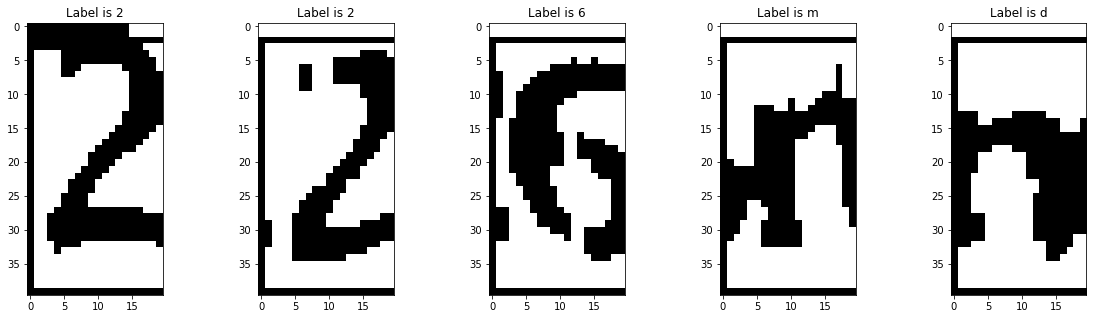

In [9]:
plt.figure(figsize = (20,5))
for i in range(5) :
    plt.subplot(1,5,i+1)
    plt.imshow(X[i], 'gray')
    plt.title('Label is ' + str(y[i]))
plt.plot()

Text(0.5, 1.0, 'Label Distribution with Used Characters')

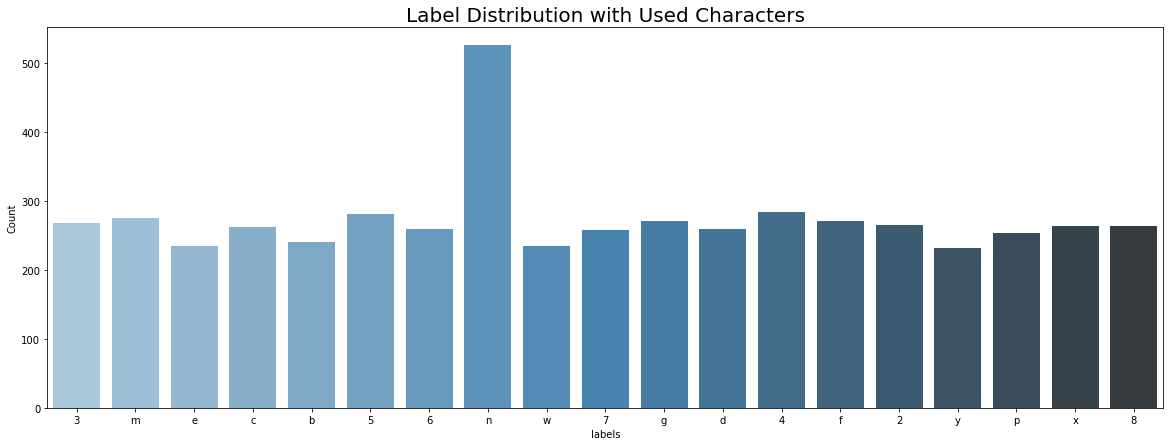

In [10]:
labels = list(set(y))
count = [len(y[y==l]) for l in labels]

data_plt = pd.DataFrame({'labels': labels, 'Count': count})

plt.figure(figsize = (20,7))
sns.barplot(x = 'labels', y = 'Count', data = data_plt, palette = 'Blues_d')
plt.title('Label Distribution with Used Characters', fontsize = 20)

Text(0.5, 1.0, 'Label Distribution with All Characters')

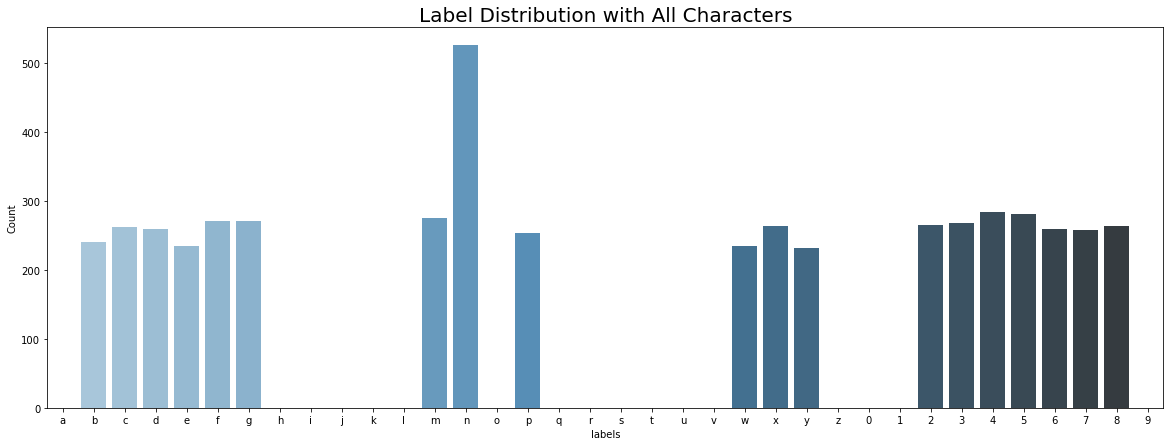

In [11]:
labels = list(string.ascii_lowercase) + list(string.digits)
count = [len(y[y==l]) for l in labels]

data_plt = pd.DataFrame({'labels': labels, 'Count': count})

plt.figure(figsize = (20,7))
sns.barplot(x = 'labels', y = 'Count', data = data_plt, palette = 'Blues_d')
plt.title('Label Distribution with All Characters', fontsize = 20)

## Split Dataset

This section generates the training set that will be used to train our models, the validation set that will be used to evaluate the models while tuning model hyperparameters, and the test set that will be used to evaluate the final models fit on the training dataset.

The training set will have 60% of the data :

- X_train with 624 images / 3120 characters, X_train shape will be (3120,40,20,1)
- y_train with 3120 labels, y_train shape will be (3120,5)

The validation set will have 20% of the data:

- X_val with 208 images / 1040 characters, X_val shape will be (1040,40,20,1)
- y_val with 1040 labels, y_val shape will be (1040,5)

The test set will have 20% of the data:

- X_test with 208 images / 1040 characters, X_test shape will be (1040,40,20,1)
- y_test  with 1040 labels, y_test shape will be (1040,5)

The label corresponding to each image is a string corresponding to the filename minus the extension. As neural networks only with numerical values, we will have to map each character in the string to an integer.


### One Hot Encoding

Here we convert our target values into binary class matrices. To know what binary class matrices look like take a look at the example below:

Y = 2 # the value 2 represents that the image has label 2

Y = [0,0,1,0,0,0,0,0,0,0] # The 2nd position in the vector is made 1

In [12]:
y_combine = LabelEncoder().fit_transform(y)
y_one_hot = OneHotEncoder(sparse = False).fit_transform(y_combine.reshape(len(y_combine),1))
info = {y_combine[i] : y[i] for i in range(len(y))}

print('digit 2 : ' + str(y[1]))
print('label : ' + str(y_combine[1]))
print('Count : ' + str(len(y_combine[y_combine == y_combine[1]])))

digit 2 : 2
label : 0
Count : 265


In [13]:
def split_data(train_size, val_size, shuffle):
    
    # Obtain number of samples
    m = len(y)
    
    # Make an indices array and shuffle it, if required
    indices = np.arange(m)
    if shuffle:
        np.random.shuffle(indices)
        
    # Get the size of training and validation samples
    train_samples = int(m * train_size/100)
    val_samples = int(m * val_size/100)
    
    # Split data into training, validation and test sets
    X_train, y_train = X[indices[:train_samples]], y_one_hot[indices[:train_samples]]
    X_val, y_val = X[indices[train_samples:(train_samples+val_samples)]], y_one_hot[indices[train_samples:(train_samples+val_samples)]]
    X_test, y_test = X[indices[(train_samples+val_samples):]], y_one_hot[indices[(train_samples+val_samples):]]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [14]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(60, 20, True)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3120, 40, 20, 1)
(1040, 40, 20, 1)
(1040, 40, 20, 1)


Text(0.5, 1.0, 'Label Distribution with Test set')

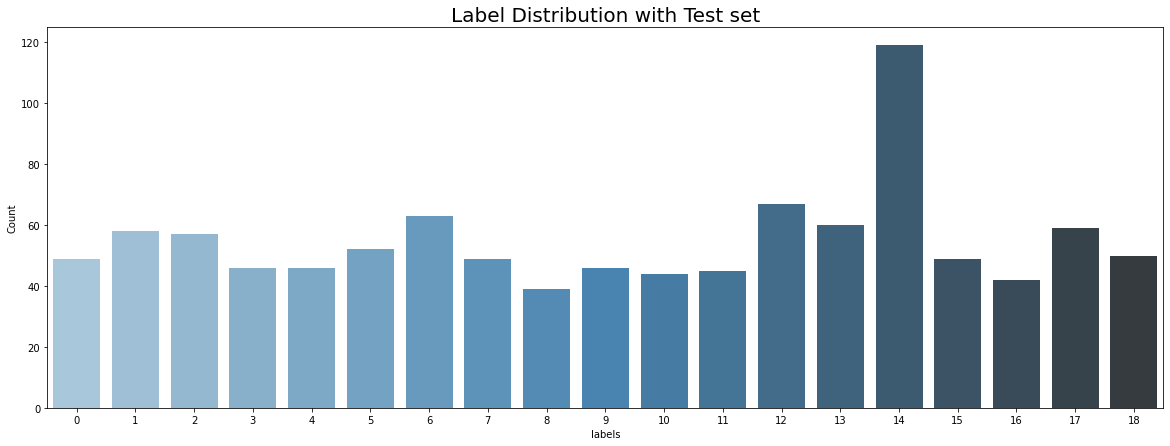

In [15]:
y_temp = np.argmax(y_test, axis = 1)

labels = list(set(y_temp))
count = [len(y_temp[y_temp==l]) for l in labels]

data_plt = pd.DataFrame({'labels': labels, 'Count': count})

plt.figure(figsize = (20,7))
sns.barplot(x = 'labels', y = 'Count', data = data_plt, palette = 'Blues_d')
plt.title('Label Distribution with Test set', fontsize = 20)

# Linear Support Vector Machine

Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection. They work by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable.

SVC implements the “one-versus-one” approach for multi-class classification. In total, n_classes * (n_classes - 1) / 2 classifiers are constructed and each one trains data from two classes

Here try different regularization parameters, ranging from C = 1 to C = 5. The strength of the regularization is inversely proportional to C. The penalty is a squared l2 penalty.

In [16]:
m = X_train.shape[0]

X_train_temp = X_train.reshape((m, 40*20))
y_train_temp = np.argmax(y_train,axis= 1)

m = X_test.shape[0]
X_test_temp = X_test.reshape((m, 40*20))
y_test_temp = np.argmax(y_test,axis= 1)

best_c = {}

for c in range(1, 6):
    
    classifier = SVC(C=c, kernel="linear")
    classifier.fit(X_train_temp, y_train_temp)

    predictions = classifier.predict(X_test_temp)

    score = metrics.accuracy_score(y_test_temp, predictions)
    print('Accuracy:', score)
    
    if not best_c or score > best_c["Score"]:
        best_c = {"C": c, "Score": score}
    
print("Best C - Score")
print(best_c)

Accuracy: 0.8163461538461538
Accuracy: 0.8153846153846154
Accuracy: 0.8153846153846154
Accuracy: 0.8153846153846154
Accuracy: 0.8153846153846154
Best C - Score
{'C': 1, 'Score': 0.8163461538461538}


## Confusion Matrix

A confusion matrix is a table that is used to describe the performance of a classification model (or “classifier”) on a set of test data for which the true values are known. In this section, we use Seaborn and Matplotlib to make confusion matrices more understandable and visually appealing.

In [17]:
cm = metrics.confusion_matrix(y_test_temp, predictions)
print(cm)

[[45  2  0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3 51  0  2  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 52  1  0  1  0  0  0  0  1  0  0  0  0  0  0  2  0]
 [ 1  3  0 37  0  1  0  0  1  1  0  2  0  0  0  0  0  0  0]
 [ 1  0  1  1 39  2  1  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 1  0  0  2  0 47  0  0  1  0  0  0  0  0  0  0  0  1  0]
 [ 0  1  0  2  5  1 50  2  0  0  0  1  1  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0 47  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  1  0  0  0 32  0  3  0  0  0  0  0  1  2  0]
 [ 0  1  0  0  1  1  0  1  3 37  0  0  1  0  0  0  1  0  0]
 [ 1  0  1  0  0  0  0  0  1  0 37  0  0  0  0  0  4  0  0]
 [ 0  0  0  2  0  0  1  0  0  1  0 40  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  1  2  2  0  0 58  0  0  2  0  1  0]
 [ 0  0  0  1  1  0  0  0  0  1  0  0  0 21 33  0  2  1  0]
 [ 0  0  0  0  2  1  0  1  3  4  1  0  0 20 84  0  1  2  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  2  2  1 43  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  1  0  0

## Seaborn

Text(0.5, 1.0, 'Accuracy Score: 0.8153846153846154')

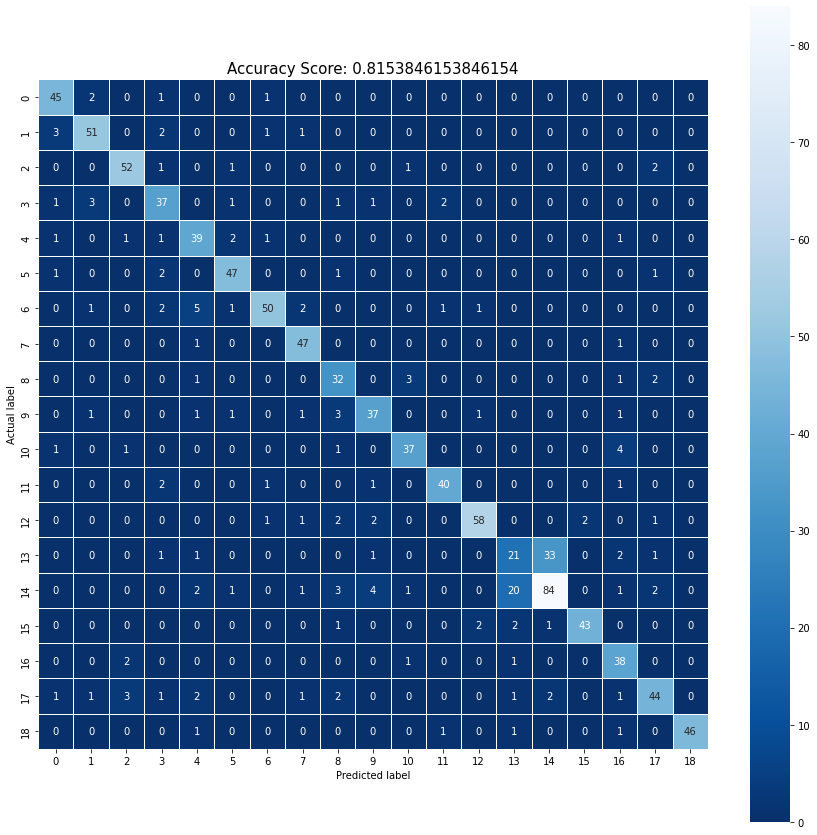

In [18]:
plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

## Misclassified images with Predicted Labels

In [19]:
index = 0
misclassifiedIndexes = []
for label, predict in zip(y_test_temp, predictions):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index +=1

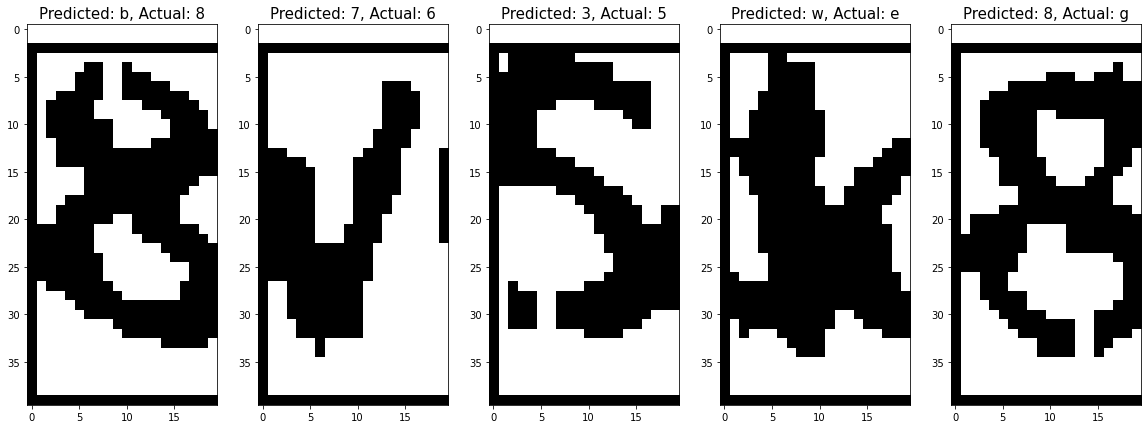

In [20]:
plt.figure(figsize=(20,7))
for plotIndex, badIndex in enumerate(misclassifiedIndexes[10:15]):
    plt.subplot(1, 5, plotIndex + 1)
    plt.imshow(X_test[badIndex], cmap=plt.cm.gray)
    
    plt.title('Predicted: {}, Actual: {}'.format(info[predictions[badIndex]], info[y_test_temp[badIndex]]), fontsize = 15)

# Convolutional Neural Network

A convolution neural network is similar to a multi-layer perceptron network.The major differences are what the network learns, how they are structured and what purpose they are mostly used for. 

Convolutional neural networks were also inspired from biological processes, their structure has a semblance of the visual cortex present in an animal. CNNs are largely applied in the domain of computer vision and has been highly successful in achieving state of the art performance on various test cases.

The hidden layers in a CNN are generally convolution and pooling (downsampling) layers. In each convolution layer, we take a filter of a small size and move that filter across the image and perform convolution operations. Convolution operations are nothing but element-wise matrix multiplication between the filter values and the pixels in the image and the resultant values are summed.

In [21]:
def conv_layer(filterx) :
    
    model = Sequential()
    
    model.add(Conv2D(filterx, (3,3), padding = 'same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    
    return model

In [22]:
def dens_layer(hiddenx) :
    
    model = Sequential()
    
    model.add(Dense(hiddenx, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    return model

In [23]:
def cnn(filter1, filter2, filter3, hidden1, hidden2) :
    
    model = Sequential()
    model.add(Input((40, 20, 1,)))
    
    model.add(conv_layer(filter1))
    model.add(conv_layer(filter2))
    model.add(conv_layer(filter3))
    
    model.add(Flatten())
    model.add(dens_layer(hidden1))
    model.add(dens_layer(hidden2))
    
    model.add(Dense(19, activation = 'softmax'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [24]:
model = cnn(128, 32, 16, 32, 32)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 20, 10, 128)       1792      
                                                                 
 sequential_2 (Sequential)   (None, 10, 5, 32)         37024     
                                                                 
 sequential_3 (Sequential)   (None, 5, 3, 16)          4688      
                                                                 
 flatten (Flatten)           (None, 240)               0         
                                                                 
 sequential_4 (Sequential)   (None, 32)                7840      
                                                                 
 sequential_5 (Sequential)   (None, 32)                1184      
                                                                 
 dense_2 (Dense)             (None, 19)                6

In [25]:
traingen = ImageDataGenerator(rotation_range = 5, width_shift_range = [-2,2])
traingen.fit(X_train)
train_set = traingen.flow(X_train, y_train)

In [26]:
history = model.fit(train_set, validation_data = (X_val, y_val), epochs = 100, steps_per_epoch = len(X_train)/32)

Epoch 1/100
97/97 [==============================] - 10s 91ms/step - loss: 2.8508 - accuracy: 0.1587 - val_loss: 2.9520 - val_accuracy: 0.0606
Epoch 2/100
97/97 [==============================] - 9s 90ms/step - loss: 2.1379 - accuracy: 0.3583 - val_loss: 3.1012 - val_accuracy: 0.0740
Epoch 3/100
97/97 [==============================] - 9s 97ms/step - loss: 1.7369 - accuracy: 0.4952 - val_loss: 3.0283 - val_accuracy: 0.1058
Epoch 4/100
97/97 [==============================] - 8s 83ms/step - loss: 1.4512 - accuracy: 0.5830 - val_loss: 2.5872 - val_accuracy: 0.2308
Epoch 5/100
97/97 [==============================] - 8s 83ms/step - loss: 1.3050 - accuracy: 0.6317 - val_loss: 2.0177 - val_accuracy: 0.3365
Epoch 6/100
97/97 [==============================] - 9s 89ms/step - loss: 1.1874 - accuracy: 0.6699 - val_loss: 1.0711 - val_accuracy: 0.7385
Epoch 7/100
97/97 [==============================] - 8s 82ms/step - loss: 1.0786 - accuracy: 0.6888 - val_loss: 0.9853 - val_accuracy: 0.7481
Epoch

## Measuring Model Performance

Text(0.5, 1.0, 'Model accuracy wrt Epoch')

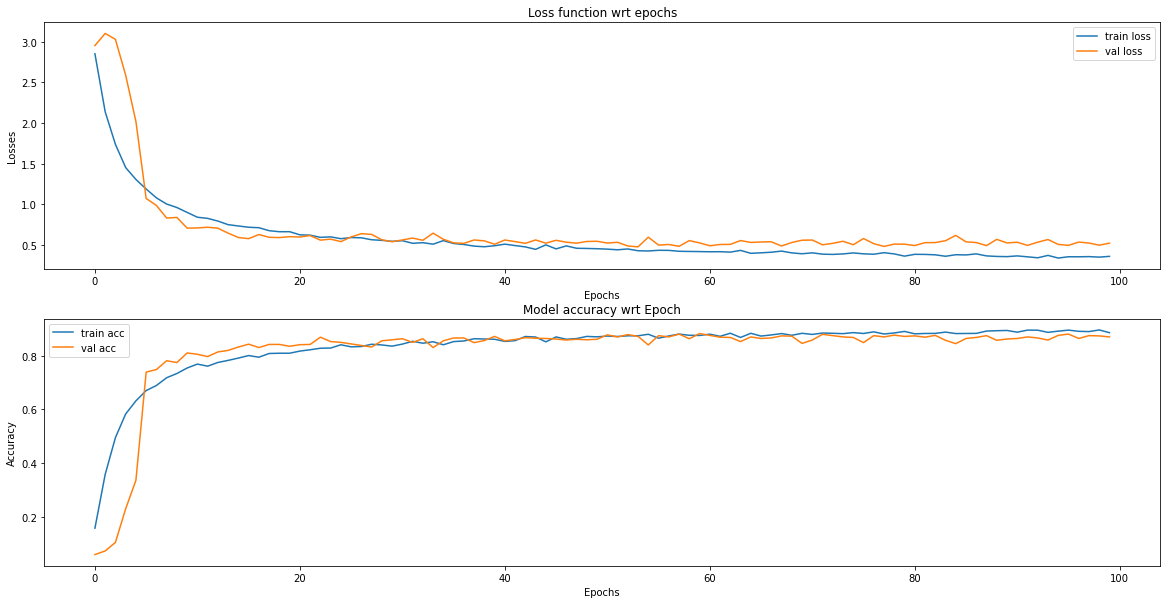

In [27]:
plt.figure(figsize = (20,10))
plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend(['train loss','val loss'])
plt.title('Loss function wrt epochs')

plt.subplot(2,1,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train acc' , 'val acc'])
plt.title('Model accuracy wrt Epoch')

In [28]:
predictions = model.predict(X_test)

predictions = np.argmax(predictions, axis = 1)
y_res = np.argmax(y_test,axis= 1)

score = metrics.accuracy_score(y_res, predictions)
print('Accuracy:', score)

Accuracy: 0.8740384615384615


In [29]:
cr = metrics.classification_report(y_res, predictions)
print(cr)

              precision    recall  f1-score   support

           0       0.90      0.96      0.93        49
           1       0.98      0.95      0.96        58
           2       0.94      0.89      0.92        57
           3       0.93      0.87      0.90        46
           4       0.92      0.96      0.94        46
           5       0.94      0.92      0.93        52
           6       0.97      0.94      0.95        63
           7       0.87      0.98      0.92        49
           8       0.83      0.74      0.78        39
           9       0.83      0.87      0.85        46
          10       0.89      0.73      0.80        44
          11       0.84      0.91      0.87        45
          12       0.97      0.96      0.96        67
          13       0.77      0.45      0.57        60
          14       0.76      0.84      0.80       119
          15       0.94      0.94      0.94        49
          16       0.62      0.98      0.76        42
          17       0.88    

## Confusion Matrix

A confusion matrix is a table that is used to describe the performance of a classification model (or “classifier”) on a set of test data for which the true values are known. In this section, we use Seaborn and Matplotlib to make confusion matrices more understandable and visually appealing.

Text(0.5, 1.0, 'Accuracy Score: 0.8740384615384615')

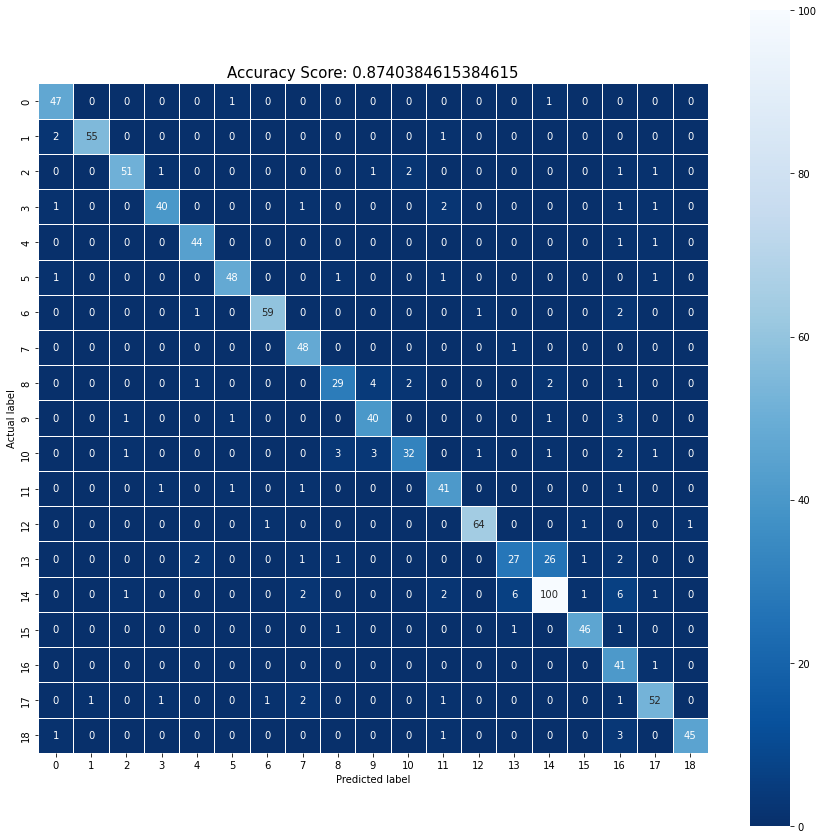

In [30]:
cm = metrics.confusion_matrix(y_res, predictions)

plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

## Misclassified images with Predicted Labels

In [31]:
index = 0
misclassifiedIndexes = []
for label, predict in zip(y_res, predictions):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index +=1

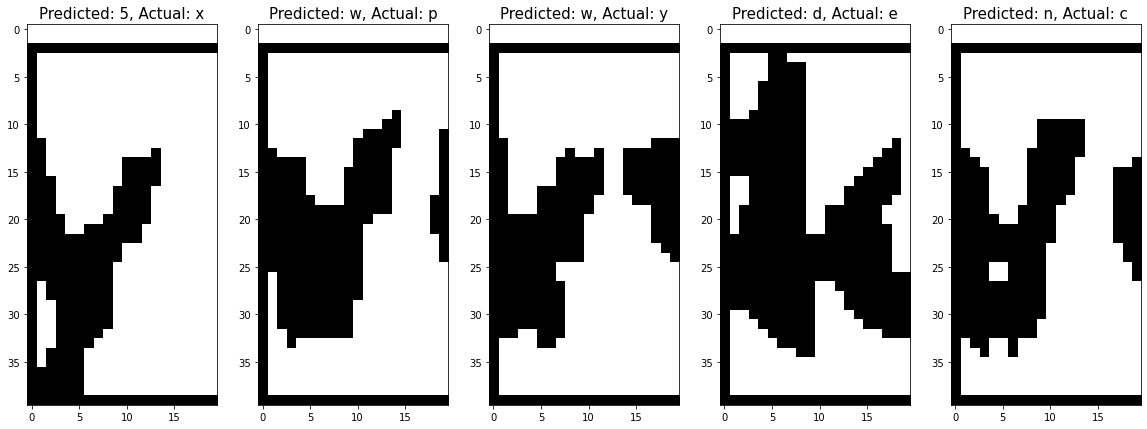

In [32]:
plt.figure(figsize=(20,7))
for plotIndex, badIndex in enumerate(misclassifiedIndexes[10:15]):
    plt.subplot(1, 5, plotIndex + 1)
    plt.imshow(X_test[badIndex], cmap=plt.cm.gray)
    
    pred = predictions[badIndex]
    yy = y_res[badIndex]
    
    plt.title('Predicted: {}, Actual: {}'.format(info[pred], info[yy]), fontsize = 15)